# Wikipedia Statistics #

This page contains some interesting statistics about paths between two articles on wikipedia. A _path_ is defined as a set of articles that can be reached from one another using only the links on thoes paths. The links are also not alowed to link outside of the main wikipedia (i.e. Talk pages and Caterory pages are not allowed). The data gathered is the result of paths between two randomly selected articles. The result is then stored in a postgresql database and retrieved in python using the `psycopg2` library.

In [1]:
import psycopg2

In [2]:
password = open('pass.txt').readlines()[0]
connection = psycopg2.connect(dbname='wikidb', user='alexander', password=password)
cursor = connection.cursor()

To make a histogram over all the paths lenght and their relative frequensy all paths are retived and counted in groups of same length using some SQL-queries.

In [3]:
cursor.execute('SELECT MAX(path_length) FROM paths;')
longest = cursor.fetchone()[0] # this is the length of the longest path
freq = {}                      # this dictionary will map path length to how many paths have that length
for path_length in range(longest + 1):
    cursor.execute('SELECT COUNT(*) FROM paths WHERE path_length=%s', (path_length,))
    freq[path_length] = cursor.fetchone()[0]

To analyze the data we first need a way to normalize the data. We also need to be able to calculate the avrage value and the standard deviation of our data set. To do this we define the following functions to do exactly that for us:

In [4]:
from math import sqrt

def normalize(freq_list):
    """
    Normalizes the given list of values so that the sum of the resulting list is equal to one.
    """
    tot_values = sum(freq_list)
    return [value/tot_values for value in freq_list]

def mean(freq):
    """
    Calculates the mean value of the given dictionary. The dictionary should contain a
    mapping between a value and its frequency.
    """
    tot_values = sum(freq.values())
    return sum(map(lambda x: x * freq[x], freq))/tot_values

def std_dev(freq, mean):
    """
    Calculates the standard deviation of the given dictionary with the specified mean value.
    The dicionary should map a value to its frequency.
    """
    tot_values = sum(freq.values())
    return sqrt(sum(map(lambda x: (x-mean)**2 * freq[x], freq))/tot_values)


## The Results ##

To actually visualize the result we'll use `matplotlib` to draw a histogram and a normal distribution curve. The mean value ($\mu$) and the standard deviation ($\sigma$) are also displayed in the graph 

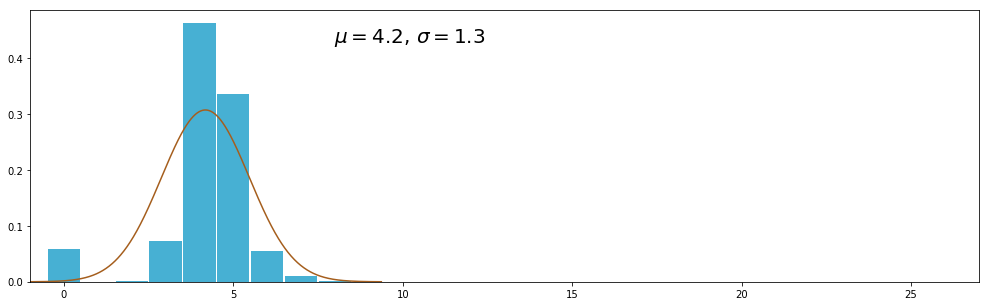

In [5]:
# Configuration needed for a nice plot
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [17,5]

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

mean_val = mean(freq)         # Calculates the mean value of the data
std = std_dev(freq, mean_val) # Calculates the standard deviation 

x = np.linspace(mean_val - 4 * std, mean_val + 4*std, 1000) # This is all the x-values over which the program
                                                            # should draw the bell curve

plt.xlim((-1,longest)) # Specifies the length of the x-axis

plt.plot(x, stats.norm.pdf(x, mean_val, std), color='#a55e1d')                    # Plots the bell curve
plt.bar(list(freq.keys()), normalize(freq.values()), width=0.95, color='#47b0d3') # Plots the histogram

# Draws the text
ax = plt.gca()
_  = plt.text(0.4, 0.9,  f'$\mu={round(mean_val, 1)}$, $\sigma={round(std, 1)}$', fontsize=20,
              horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

Unfortunetly the normal distribution does not match up that well with the actual results. The is mostly due to all the paths with length 0 i.e. pairs of articles that did not have a path in between. Therefore it doesn't really make sence to include it in the data so if we replot the histogram and the gausian distribution we get a much nicer result.

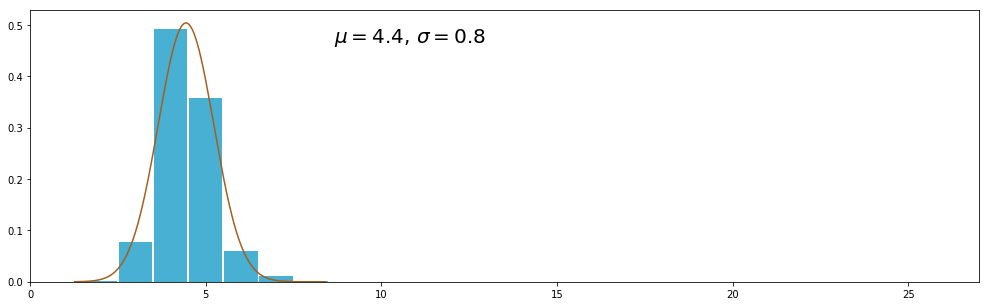

In [6]:
matplotlib.rcParams['figure.figsize'] = [17,5]

filtered_freq = {x:freq[x] for x in freq if x != 0} # This keeps all the values as long as the path length is not 0

mean_val = mean(filtered_freq)
std = std_dev(filtered_freq, mean_val)

x = np.linspace(mean_val - 4 * std, mean_val + 5*std, 1000)


plt.xlim((0, longest))

plt.plot(x, stats.norm.pdf(x, mean_val, std), color='#a55e1d')
plt.bar(list(freq.keys())[1:], normalize(list(freq.values())[1:]), width=0.95, color='#47b0d3')


ax = plt.gca()
_  = plt.text(0.4, 0.9,  f'$\mu={round(mean_val, 1)}$, $\sigma={round(std, 1)}$', fontsize=20,
              horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

Now the distribution curve aligns much more nicely with the histogram!

## Longest Path ## 

Another point of intrest is the longest path found so far. The longest path found so far is between the following two articles:

In [7]:
from database import WikiDatabase

wikidb = WikiDatabase('wikidb', user='alexander', password=password)

cursor.execute('SELECT example_path FROM paths WHERE path_length=%s', (longest,))

longest_path = list(map(lambda x: x.replace('_', ' '), wikidb.get_titles_of_ids(tuple(cursor.fetchone()[0]))))
print(f"'{longest_path[0]}' -> '{longest_path[-1]}'")

'Xihua' -> 'Billboard Top Hits: 1988'


And the entire path is as follows:

In [8]:
longest_path

['Xihua',
 'Xihua County',
 'Time zone',
 'Illinois',
 'Soul music',
 'Dan Penn',
 'Cry Like a Baby',
 "Billboard Top Rock'n'Roll Hits: 1968",
 "Billboard Top Rock'n'Roll Hits: 1969",
 "Billboard Top Rock'n'Roll Hits: 1970",
 "Billboard Top Rock'n'Roll Hits: 1971",
 "Billboard Top Rock'n'Roll Hits: 1972",
 "Billboard Top Rock'n'Roll Hits: 1973",
 "Billboard Top Rock'n'Roll Hits: 1974",
 'Billboard Top Hits: 1975',
 'Billboard Top Hits: 1976',
 'Billboard Top Hits: 1977',
 'Billboard Top Hits: 1978',
 'Billboard Top Hits: 1979',
 'Billboard Top Hits: 1980',
 'Billboard Top Hits: 1981',
 'Billboard Top Hits: 1982',
 'Billboard Top Hits: 1983',
 'Billboard Top Hits: 1984',
 'Billboard Top Hits: 1985',
 'Billboard Top Hits: 1986',
 'Billboard Top Hits: 1987',
 'Billboard Top Hits: 1988']